In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
path = os.path.abspath(os.path.join(os.getcwd(),".."))
print(path)
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
from dynamics_predict.dynamics_networks import DynamicsNetwork, EncoderDynamicsNetwork, EncoderDecoderDynamicsNetwork, VAEDynamicsNetwork
from rl.policy_networks import DPG_PolicyNetwork
from utils.load_params import load_params
from utils.common_func import rand_params
from dynamics_predict.defaults import DYNAMICS_PARAMS, HYPER_PARAMS
from environment import envs
import torch



/home/quantumiracle/research/COS513_project/src


In [2]:
env_name = 'inverteddoublependulum'
data_path = path+'/data/dynamics_data/'+env_name+'/dynamics.npy'
param_dim = len(DYNAMICS_PARAMS[env_name+'dynamics'])
print('parameter dimension: ', param_dim)

parameter dimension:  5


In [3]:
train_data = np.load(data_path, allow_pickle=True)
print('number of samples in test data: ', len(train_data))
# split data
def split_data(data, partial=100000):
    data_s, data_a, data_param, data_s_ = [], [], [], []
    for d in data[:partial]:
        [s,a,param], s_ = d
        data_s.append(s)
        data_a.append(a)
        data_param.append(param)
        data_s_.append(s_)

    data_s = np.array(data_s)
    data_a = np.array(data_a)
    data_param = np.array(data_param)
    data_s_ = np.array(data_s_)
    
    return data_s, data_a, data_param, data_s_

data_s, data_a, data_param, data_s_ = split_data(train_data)
print(data_s.shape, data_a.shape, data_param.shape, data_s_.shape)

number of samples in dest data:  5823798
(100000, 11) (100000, 1) (100000, 5) (100000, 11)


In [5]:
state_dim = data_s.shape[1]
action_dim = data_a.shape[1]
param_dim = data_param.shape[1]
latent_dim = 2
switch_dim = 5

model_save_path = f'../data/weights/dynamics/inverteddoublependulum/'
os.makedirs(model_save_path, exist_ok=True)

## Switch Linear Dynamics

In [8]:
from torch.distributions import Normal
import torch.nn.functional as F
import torch.nn as nn

device = 'cuda'

class DynamicsParamsOptimizer():
    """ 
    Dynamics parameters optimization model (gradient-based) based on a trained 
    forward dynamics prediction network: (s, a, learnable_params) -> s_ with real-world data. 
    """
    def __init__(self, state_dim, action_dim, param_dim, latent_dim, switch_dim, model_save_path):
        self.model = SLDynamicsNetwork(state_dim, action_dim, param_dim, latent_dim, switch_dim).to(device)
        self.criterion = nn.MSELoss()
        self.model_save_path = model_save_path

    def train(self, s, a, theta, s_, epoch):
        """ s,a concat with param (learnable) -> s_ """
        if not isinstance(s_, torch.Tensor):
            s_ = torch.Tensor(s_).to(device)

        for ep in range(epoch):
            s_pred = self.model.forward(s, a, theta)
            self.model.optimizer.zero_grad()
            loss = self.criterion(s_pred, s_)
            loss.backward()
            self.model.optimizer.step()
            if ep%100==0:
                print('epoch: {}, loss: {}'.format(ep, loss.item()))
                torch.save(self.model.state_dict(), self.model_save_path+'model')
            

class SLDynamicsNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, param_dim, latent_dim, switch_dim, lr=1e-4):
        super(SLDynamicsNetwork, self).__init__()
        self.state_dim = state_dim
        self.A = nn.Parameter(torch.rand((switch_dim, latent_dim, state_dim, state_dim)), requires_grad=True)
        self.B = nn.Parameter(torch.rand((switch_dim, latent_dim, state_dim, action_dim)), requires_grad=True)
        self.E = nn.Parameter(torch.rand((param_dim, latent_dim)), requires_grad=True)
        self.switch_logits = nn.Sequential(
            nn.Linear(state_dim, switch_dim, bias=False)  # only weight matrix, no bias
        )
        # print(dict(self.named_parameters()))

        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

    def gaussian_noise(self, shape, scale):
        normal = Normal(0, 1)
        epsilon = scale * normal.sample(shape) 
        return epsilon

    def get_switch_var(self, s):
        logits_ = self.switch_logits(s)
        switch_var = F.gumbel_softmax(logits_, tau=1, hard=True)  # if hard, return one-hot
        return switch_var

    def get_s_before_encode(self, s, a):
        switch_var = self.get_switch_var(s)
        A_w = torch.einsum('ab,bcde->acde', switch_var, self.A) # chosen by the switch variable; shape (#batch, #latent, #state, #state)
        B_w = torch.einsum('ab,bcde->acde', switch_var, self.B) # chosen by the switch variable; shape (#batch, #latent, #state, #action)
        s_before_encode = torch.einsum('abcd,ad->abc', A_w, s) + torch.einsum('abcd,ad->abc', B_w, a)  # shape (#batch, #latent, #state)
        return s_before_encode

    def forward(self, s, a, theta):
        if not isinstance(s, torch.Tensor):
            s = torch.Tensor(s).to(device)
        if not isinstance(a, torch.Tensor):
            a = torch.Tensor(a).to(device)
        if not isinstance(theta, torch.Tensor):
            theta = torch.Tensor(theta).to(device)
        batch_size = s.shape[0]

        s_before_encode = self.get_s_before_encode(s, a)
        s_before_noise = torch.einsum('ab,abc->ac', theta@self.E, s_before_encode)  # shape (#batch, #state)
        noise = self.gaussian_noise(shape=(batch_size, self.state_dim), scale=0.)
        s_ = s_before_noise + noise.to(device)

        return s_

    def get_latent_code(self, s, a, s_):
        if not isinstance(s, torch.Tensor):
            s = torch.Tensor(s).to(device).to(device)
        if not isinstance(a, torch.Tensor):
            a = torch.Tensor(a).to(device)        
        if not isinstance(s_, torch.Tensor):
            s_ = torch.Tensor(s_).to(device)     

        s_before_encode = self.get_s_before_encode(s, a)
        inv_s = torch.linalg.pinv(s_before_encode)  # pseudo-inverse; shape (#batch, #state, #latent)
        alpha = torch.einsum('ab,abc->ac', s_, inv_s)
        print(s_before_encode.shape, inv_s.shape, alpha.shape)

        return alpha



In [35]:
import os

# train
updater = DynamicsParamsOptimizer(state_dim, action_dim, param_dim, latent_dim, switch_dim, model_save_path)
updater.train(data_s, data_a, data_param, data_s_, epoch=100000)

epoch: 0, loss: 324.5203857421875
epoch: 100, loss: 298.9375305175781
epoch: 200, loss: 276.59454345703125
epoch: 300, loss: 255.57992553710938
epoch: 400, loss: 236.47393798828125
epoch: 500, loss: 219.1861572265625
epoch: 600, loss: 203.21389770507812
epoch: 700, loss: 188.7410888671875
epoch: 800, loss: 175.6169891357422
epoch: 900, loss: 163.41543579101562
epoch: 1000, loss: 152.49801635742188
epoch: 1100, loss: 141.8196258544922
epoch: 1200, loss: 131.9557647705078
epoch: 1300, loss: 122.83441162109375
epoch: 1400, loss: 114.36428833007812
epoch: 1500, loss: 106.8127670288086
epoch: 1600, loss: 99.80718994140625
epoch: 1700, loss: 92.93031311035156
epoch: 1800, loss: 86.51558685302734
epoch: 1900, loss: 80.93875885009766
epoch: 2000, loss: 75.38483428955078
epoch: 2100, loss: 70.01204681396484
epoch: 2200, loss: 65.4825439453125
epoch: 2300, loss: 61.2170295715332
epoch: 2400, loss: 57.09694290161133
epoch: 2500, loss: 53.214298248291016
epoch: 2600, loss: 49.67768859863281
epoch:

epoch: 21200, loss: 0.06783156096935272
epoch: 21300, loss: 0.06736885011196136
epoch: 21400, loss: 0.067563995718956
epoch: 21500, loss: 0.0672747939825058
epoch: 21600, loss: 0.06718931347131729
epoch: 21700, loss: 0.0669659674167633
epoch: 21800, loss: 0.06686516106128693
epoch: 21900, loss: 0.06701202690601349
epoch: 22000, loss: 0.06636428833007812
epoch: 22100, loss: 0.06603124737739563
epoch: 22200, loss: 0.06601136922836304
epoch: 22300, loss: 0.06565732508897781
epoch: 22400, loss: 0.06536722928285599
epoch: 22500, loss: 0.0654047280550003
epoch: 22600, loss: 0.0649365559220314
epoch: 22700, loss: 0.06472795456647873
epoch: 22800, loss: 0.06455153971910477
epoch: 22900, loss: 0.063878633081913
epoch: 23000, loss: 0.06314877420663834
epoch: 23100, loss: 0.06321681290864944
epoch: 23200, loss: 0.0629044622182846
epoch: 23300, loss: 0.06220986321568489
epoch: 23400, loss: 0.0622527040541172
epoch: 23500, loss: 0.0621127188205719
epoch: 23600, loss: 0.060918863862752914
epoch: 237

epoch: 41600, loss: 0.02844228409230709
epoch: 41700, loss: 0.028348887339234352
epoch: 41800, loss: 0.02816794253885746
epoch: 41900, loss: 0.028217464685440063
epoch: 42000, loss: 0.028120433911681175
epoch: 42100, loss: 0.028264807537198067
epoch: 42200, loss: 0.028165804222226143
epoch: 42300, loss: 0.02813138999044895
epoch: 42400, loss: 0.027977805584669113
epoch: 42500, loss: 0.028132684528827667
epoch: 42600, loss: 0.02814204804599285
epoch: 42700, loss: 0.02795899473130703
epoch: 42800, loss: 0.027983855456113815
epoch: 42900, loss: 0.027998581528663635
epoch: 43000, loss: 0.02822699211537838
epoch: 43100, loss: 0.02795564942061901
epoch: 43200, loss: 0.02814740315079689
epoch: 43300, loss: 0.027959927916526794
epoch: 43400, loss: 0.028044959530234337
epoch: 43500, loss: 0.02791566029191017
epoch: 43600, loss: 0.02797209471464157
epoch: 43700, loss: 0.027946529909968376
epoch: 43800, loss: 0.028044044971466064
epoch: 43900, loss: 0.027942173182964325
epoch: 44000, loss: 0.0277

epoch: 61900, loss: 0.02667098306119442
epoch: 62000, loss: 0.026447294279932976
epoch: 62100, loss: 0.02672390080988407
epoch: 62200, loss: 0.026692984625697136
epoch: 62300, loss: 0.02659653313457966
epoch: 62400, loss: 0.02674417570233345
epoch: 62500, loss: 0.026821691542863846
epoch: 62600, loss: 0.026895085349678993
epoch: 62700, loss: 0.027237899601459503
epoch: 62800, loss: 0.027037274092435837
epoch: 62900, loss: 0.026589376851916313
epoch: 63000, loss: 0.026618776842951775
epoch: 63100, loss: 0.02692478522658348
epoch: 63200, loss: 0.026853717863559723
epoch: 63300, loss: 0.026863250881433487
epoch: 63400, loss: 0.026484567672014236
epoch: 63500, loss: 0.026811610907316208
epoch: 63600, loss: 0.027249246835708618
epoch: 63700, loss: 0.02670368179678917
epoch: 63800, loss: 0.026435554027557373
epoch: 63900, loss: 0.026951422914862633
epoch: 64000, loss: 0.026704825460910797
epoch: 64100, loss: 0.026533402502536774
epoch: 64200, loss: 0.027012605220079422
epoch: 64300, loss: 0.

epoch: 82100, loss: 0.02634407766163349
epoch: 82200, loss: 0.026389967650175095
epoch: 82300, loss: 0.026433920487761497
epoch: 82400, loss: 0.026147620752453804
epoch: 82500, loss: 0.026148224249482155
epoch: 82600, loss: 0.02615172043442726
epoch: 82700, loss: 0.026178134605288506
epoch: 82800, loss: 0.026056088507175446
epoch: 82900, loss: 0.02637457847595215
epoch: 83000, loss: 0.026187947019934654
epoch: 83100, loss: 0.026124171912670135
epoch: 83200, loss: 0.026237808167934418
epoch: 83300, loss: 0.026216696947813034
epoch: 83400, loss: 0.026526469737291336
epoch: 83500, loss: 0.026118941605091095
epoch: 83600, loss: 0.025985104963183403
epoch: 83700, loss: 0.02625962346792221
epoch: 83800, loss: 0.026196878403425217
epoch: 83900, loss: 0.026420727372169495
epoch: 84000, loss: 0.026052460074424744
epoch: 84100, loss: 0.026229022070765495
epoch: 84200, loss: 0.026026099920272827
epoch: 84300, loss: 0.026179909706115723
epoch: 84400, loss: 0.026186442002654076
epoch: 84500, loss: 

In [71]:
import numpy

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def display_points(predict_x,true_x):
#     plt.xlim(0,5)
#     plt.ylim(-3,1)
    predict_x = np.array(predict_x)
    true_x = np.array(true_x)
#     colors = get_cmap(predict_x.shape[0])
    
    for i, (x, x_) in enumerate(zip(predict_x, true_x)):
        c=numpy.random.rand(3,)
        plt.plot(*x,"*", c=c, markersize=10)
        plt.plot(*x_,"^", c=c, markersize=8)  
    plt.savefig('sld.png')
    plt.show()

In [35]:
# load test data
test_data_path = path+'/data/dynamics_data/'+env_name+'/test_dynamics.npy'
test_data = np.load(test_data_path, allow_pickle=True)
print('number of samples in dest data: ', len(test_data))
idx=5  # index of sample to test: 0-10
test_s = np.array(test_data[idx]['sa'])[:, :-1]
test_a = np.array(test_data[idx]['sa'])[:, -1:]
test_param = np.array(test_data[idx]['params'])
test_s_ = np.array(test_data[idx]['s_'])
print(test_s.shape, test_a.shape, test_param.shape, test_s_.shape)

# load model
updater = DynamicsParamsOptimizer(state_dim, action_dim, param_dim, latent_dim, switch_dim, model_save_path)
updater.model.load_state_dict(torch.load(model_save_path+'model', map_location=device))

number of samples in dest data:  10
(275717, 11) (275717, 1) (5,) (275717, 11)


<All keys matched successfully>

torch.Size([10, 2, 11]) torch.Size([10, 11, 2]) torch.Size([10, 2])
tensor([[ 2.8067, -1.7656],
        [ 2.3687, -1.2460],
        [ 2.6240, -1.4660],
        [ 2.6398, -1.4809],
        [ 2.8436, -1.8056],
        [ 1.4809,  0.1059],
        [ 2.4902, -1.3275],
        [ 2.7514, -1.6052],
        [ 2.9631, -1.8194],
        [ 2.4582, -1.3334]], device='cuda:0', grad_fn=<ViewBackward>) [ 2.5426657 -1.3743666] [[ 2.651606  -1.5125511]]


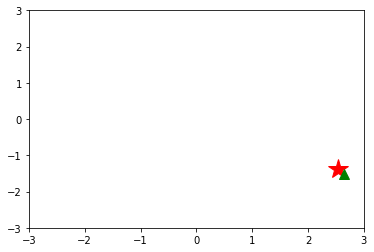

In [41]:
partial = 10
alpha = updater.model.get_latent_code(test_s[:partial], test_a[:partial], test_s_[:partial])
average_alpha = alpha.mean(dim=0).detach().cpu().numpy()

# compare with encoded value
alpha_ = (torch.Tensor([test_param]).to(device)@updater.model.E).detach().cpu().numpy()
print(alpha, average_alpha, alpha_)

display_points([average_alpha], alpha_)

In [46]:
# load test data
test_data_path = path+'/data/dynamics_data/'+env_name+'/test_dynamics.npy'
test_data = np.load(test_data_path, allow_pickle=True)
print('number of samples in dest data: ', len(test_data))

number of samples in dest data:  10


(189988, 11) (189988, 1) (5,) (189988, 11)
torch.Size([10, 2, 11]) torch.Size([10, 11, 2]) torch.Size([10, 2])
[ 2.6493506 -1.5472585] [ 2.617456  -1.4695983]
(117608, 11) (117608, 1) (5,) (117608, 11)
torch.Size([10, 2, 11]) torch.Size([10, 11, 2]) torch.Size([10, 2])
[ 3.679095  -2.8840253] [ 3.420619 -2.491965]
(288323, 11) (288323, 1) (5,) (288323, 11)
torch.Size([10, 2, 11]) torch.Size([10, 11, 2]) torch.Size([10, 2])
[ 2.5891635 -1.4313912] [ 2.8361316 -1.6551087]


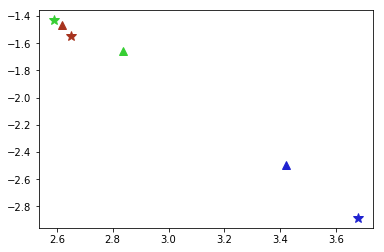

In [72]:

data_alpha, data_alpha_ = [], []

for idx in range(3):
#     idx=5  # index of sample to test: 0-10
    test_s = np.array(test_data[idx]['sa'])[:, :-1]
    test_a = np.array(test_data[idx]['sa'])[:, -1:]
    test_param = np.array(test_data[idx]['params'])
    test_s_ = np.array(test_data[idx]['s_'])
    print(test_s.shape, test_a.shape, test_param.shape, test_s_.shape)

    # load model
    updater = DynamicsParamsOptimizer(state_dim, action_dim, param_dim, latent_dim, switch_dim, model_save_path)
    updater.model.load_state_dict(torch.load(model_save_path+'model', map_location=device))

    partial = 10
    alpha = updater.model.get_latent_code(test_s[:partial], test_a[:partial], test_s_[:partial])
    average_alpha = alpha.mean(dim=0).detach().cpu().numpy()

    # compare with encoded value
    alpha_ = (torch.Tensor([test_param]).to(device)@updater.model.E)[0].detach().cpu().numpy()
    print(average_alpha, alpha_)
    data_alpha.append(average_alpha)
    data_alpha_.append(alpha_)

display_points(data_alpha, data_alpha_)

In [37]:
# test on train data
test_size = 20
test_s = data_s[:test_size]
test_a = data_a[:test_size]
test_param = data_param[:test_size]
test_s_ = data_s_[:test_size]

alpha = updater.model.get_latent_code(test_s, test_a, test_s_)

# compare with encoded value
alpha_ = torch.Tensor(test_param)@updater.model.E
print(alpha, alpha_)


torch.Size([20, 2, 11]) torch.Size([20, 11, 2]) torch.Size([20, 2])
tensor([[ 2.2643, -1.8454],
        [ 2.8811, -2.2793],
        [ 3.5958, -2.9697],
        [ 1.7742, -1.4963],
        [ 2.4365, -2.0887],
        [ 2.2297, -1.8889],
        [ 1.8014, -1.4508],
        [ 2.7828, -2.4257],
        [ 3.4125, -2.8278],
        [ 1.7107, -1.3469],
        [ 2.0031, -1.6024],
        [ 2.5392, -2.0994],
        [ 3.7406, -3.1136],
        [ 1.4040, -1.1620],
        [ 2.3428, -1.9775],
        [ 4.2024, -3.5203],
        [ 1.4234, -1.1618],
        [ 1.6157, -1.2830],
        [ 1.8207, -1.4661],
        [ 2.3034, -1.9059]], grad_fn=<ViewBackward>) tensor([[ 2.3339, -1.8811],
        [ 2.3339, -1.8811],
        [ 2.3339, -1.8811],
        [ 2.3339, -1.8811],
        [ 2.3339, -1.8811],
        [ 2.3339, -1.8811],
        [ 2.3339, -1.8811],
        [ 2.3339, -1.8811],
        [ 2.3339, -1.8811],
        [ 2.3339, -1.8811],
        [ 2.3339, -1.8811],
        [ 2.3339, -1.8811],
        [ 2